In [3]:
# 项目的 脚本 在 /root/GanLuo/ICML2025_project/scripts_pushpull/run_push_pull_track_grad_norm.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleFCN(nn.Module):
    def __init__(self):
        super(SimpleFCN, self).__init__()
        # 扩大隐藏层宽度（显著增加模型容量）
        self.fc1 = nn.Linear(784, 1024)          # 第一层：784 → 1024
        self.fc2 = nn.Linear(1024, 1024)         # 第二层：1024 → 1024
        self.fc3 = nn.Linear(1024, 10)           # 输出层：1024 → 10
        
        # He初始化（适配ReLU激活函数）
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='linear')  # 输出层用线性初始化

    def forward(self, x):
        x = x.view(x.size(0), -1)                # 展平为一维向量
        x = F.relu(self.fc1(x))                  # 第一层 + ReLU
        x = F.relu(self.fc2(x))                  # 第二层 + ReLU
        x = self.fc3(x)                          # 输出层（无激活函数）
        return x

In [6]:
def compute_avg_gradient_matrix_norm_old(model_list):
    # 假设所有模型结构相同，取第一个模型的总参数量
    num_params = sum(p.numel() for p in model_list[0].parameters() if p.grad is not None)
    num_models = len(model_list)
    
    # 初始化一个张量来存储所有模型的梯度向量
    all_grads = torch.zeros(num_models, num_params)
    
    # 对每个模型拼接梯度向量
    for i, model in enumerate(model_list):
        grads = [param.grad.view(-1) for param in model.parameters() if param.grad is not None]
        if grads:  # 确保有梯度
            grad_vector = torch.cat(grads)
            all_grads[i] = grad_vector
    
    # 计算平均梯度向量
    avg_grad = all_grads.mean(dim=0)  # 按模型维度取平均
    
    # 计算平均梯度向量的 norm 并归一化
    avg_norm = avg_grad.norm(2) / (num_params ** 0.5)  # 归一化
    
    return avg_norm.item()

In [7]:
import torch

def compute_avg_gradient_matrix_norm_new(model_list):
    num_models = len(model_list)
    if num_models == 0:
        return 0.0
    
    # 存储所有参数的平均梯度
    avg_grads = []
    total_params = 0
    
    # 假设所有模型结构相同，取第一个模型作为参考
    ref_model = model_list[0]
    
    # 对每一组对应参数的梯度取平均
    for param_name, ref_param in ref_model.named_parameters():
        if ref_param.grad is not None:  # 确保参考模型有梯度
            # 收集所有模型中该参数的梯度
            param_grads_list = [dict(model.named_parameters())[param_name].grad 
                               for model in model_list 
                               if dict(model.named_parameters())[param_name].grad is not None]
            if not param_grads_list:  # 如果所有模型的该参数梯度都为 None
                continue  # 跳过这个参数
            param_grads = torch.stack(param_grads_list)
            # 对该参数的梯度取平均
            avg_grad = param_grads.mean(dim=0)
            avg_grads.append(avg_grad.view(-1))  # 展平并添加到列表
            total_params += ref_param.numel()  # 统计参数数量
    
    if not avg_grads:  # 如果没有任何参数有梯度
        return 0.0
    
    # 拼接所有平均梯度
    avg_grad_vector = torch.cat(avg_grads)
    
    # 计算 norm 并归一化
    avg_norm = avg_grad_vector.norm(2) / (total_params ** 0.5)
    
    return avg_norm.item()

# 测试代码
class SimpleFCN(torch.nn.Module):
    def __init__(self):
        super(SimpleFCN, self).__init__()
        self.fc1 = torch.nn.Linear(784, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 10)
        torch.nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='linear')

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_list = [SimpleFCN() for _ in range(2)]
inputs = torch.randn(32, 784)
targets = torch.randint(0, 10, (32,))
criterion = torch.nn.CrossEntropyLoss()

for model in model_list:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()

avg_norm = compute_avg_gradient_matrix_norm_new(model_list)
avg_norm2 = compute_avg_gradient_matrix_norm_old(model_list)
print(f"Normalized average gradient matrix norm: {avg_norm}")
print(f"Normalized average gradient matrix norm (old): {avg_norm2}")

Normalized average gradient matrix norm: 0.006053329911082983
Normalized average gradient matrix norm (old): 0.006053329911082983


In [8]:
df1 = pd.read_csv('./output/grad_norm_Exp_test, PushPull, lr=0.01, n_nodes=16, batch_size=16, 2025-03-22.csv')
df2 = pd.read_csv('./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=16, batch_size=16, 2025-03-22.csv')
df3 = pd.read_csv('./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=4, batch_size=128, 2025-03-22.csv')
df4 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=12, batch_size=128, 2025-03-22.csv")

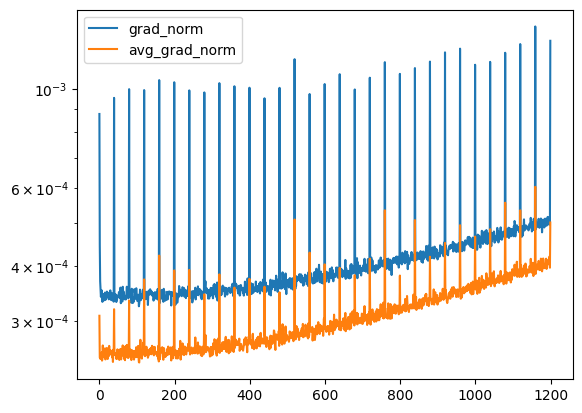

In [9]:
df4 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=12, batch_size=128, 2025-03-22.csv")
plt.semilogy(df4["grad_norm"], label="grad_norm")
plt.semilogy(df4["avg_grad_norm"], label="avg_grad_norm")
plt.legend()
plt.show()

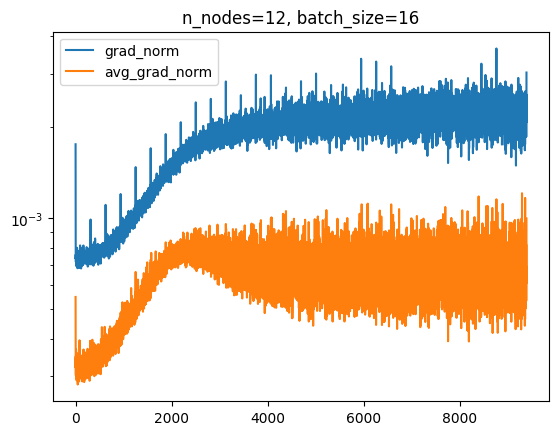

In [10]:
df4 = pd.read_csv("./output/grad_norm_Exp_test, PushPull, lr=0.001, n_nodes=12, batch_size=16, 2025-03-22.csv")
plt.semilogy(df4["grad_norm"], label="grad_norm")
plt.semilogy(df4["avg_grad_norm"], label="avg_grad_norm")
plt.title("n_nodes=12, batch_size=16")
plt.legend()
plt.show()

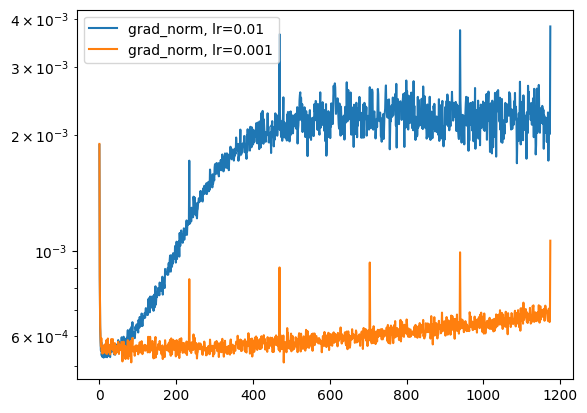

In [11]:
plt.semilogy(df1["grad_norm"], label="grad_norm, lr=0.01")
plt.semilogy(df2["grad_norm"], label="grad_norm, lr=0.001")
plt.legend()
plt.show()